# Metallicity Fit - NGC 628
Except we'll use a strong prior around the metallicity from Groves+(2023), since we don't have line information and the
broad-band photometry is not that informative about metallicity in the bands we have. This should give us a slightly different (and more uncertain) solution for the SFH than our established Solar-metallicity solution from Lightning.

## Imports

In [3]:
import numpy as np
import h5py
rng = np.random.default_rng()
import astropy.units as u
from astropy.table import Table
from corner import corner
import matplotlib.pyplot as plt
plt.style.use('ebm-dejavu')
%matplotlib inline

from lightning import Lightning
from lightning.priors import UniformPrior, NormalPrior

## NGC 628
Is probably a better target here since it's in the PHANGS sample, and we have a decent constraint on its metallicity.

First with BPASS:

In [4]:
cat = Table.read('../photometry/ngc628_dale17_photometry.fits')

# Some annoyance with converting table columns to flat numpy arrays and text encoding:
# strings come in as bytestrings (unencoded) by default python wants UTF-8, I think.
# The labels are also padded with spaces.
filter_labels = np.array([s.decode().strip() for s in cat['FILTER_LABELS'].data[0]])
fnu_obs = cat['FNU_OBS'].data[0]
fnu_unc = cat['FNU_UNC'].data[0]
dl = cat['LUMIN_DIST'].data[0]

# print('PEGASE setup:')
# lgh_pg = Lightning(filter_labels, 
#                    lum_dist=dl, 
#                    stellar_type='PEGASE',
#                    SFH_type='Piecewise-Constant',
#                    atten_type='Modified-Calzetti',
#                    dust_emission=True,
#                    model_unc=0.10,
#                    print_setup_time=True)

print('BPASS setup:')
lgh_bp = Lightning(filter_labels, 
                   lum_dist=dl, 
                   stellar_type='BPASS',
                   SFH_type='Piecewise-Constant',
                   atten_type='Modified-Calzetti',
                   dust_emission=True,
                   model_unc=0.10,
                   print_setup_time=True)

# lgh_pg.flux_obs = fnu_obs * 1e3
# lgh_pg.flux_unc = fnu_unc * 1e3

lgh_bp.flux_obs = fnu_obs * 1e3
lgh_bp.flux_unc = fnu_unc * 1e3

# lgh_pg.save_json('ngc337_config.json')
# lgh_bp.save_json('ngc337_config_BPASS.json')

BPASS setup:
0.174 s elapsed in _get_filters
0.001 s elapsed in _get_wave_obs
4.771 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
1.423 s elapsed in dust emission model setup
0.000 s elapsed in agn emission model setup
0.000 s elapsed in X-ray model setup
6.369 s elapsed total


In [5]:
lgh_bp.print_params()
lgh_bp.print_params(verbose=True)

['psi_1', 'psi_2', 'psi_3', 'psi_4', 'psi_5']
['Zmet', 'logU']
['mcalz_tauV_diff', 'mcalz_delta', 'mcalz_tauV_BC']
['dl07_dust_alpha', 'dl07_dust_U_min', 'dl07_dust_U_max', 'dl07_dust_gamma', 'dl07_dust_q_PAH']

Total parameters: 15

Piecewise-Constant
Parameter  Lo  Hi              Description
--------- --- --- ------------------------
    psi_1 0.0 inf SFR in stellar age bin 1
    psi_2 0.0 inf SFR in stellar age bin 2
    psi_3 0.0 inf SFR in stellar age bin 3
    psi_4 0.0 inf SFR in stellar age bin 4
    psi_5 0.0 inf SFR in stellar age bin 5

BPASS-Stellar
Parameter    Lo   Hi                                      Description
--------- ----- ---- ------------------------------------------------
     Zmet 1e-05 0.04 Metallicity (mass fraction, where solar = 0.020)
     logU  -4.0 -1.0                log10 of the ionization parameter

Modified-Calzetti
      Parameter   Lo  Hi                                              Description
--------------- ---- --- -------------------------

In [6]:
# p0_pg = np.array([5,5,0,0,0,
#                0.1, -1.0, 0.0,
#                2, 3, 3e5, 0.01, 0.02])

p0_seed_bp = np.array([5,5,0,0,0,
                       0.014, -2.0,
                       0.1, -1.0, 0.0,
                       2, 3, 3e5, 0.01, 0.02])

# bounds_pg = [(0,10), (0,10), (0,10), (0,10), (0,10),
#              (0,3),(-3,3),(0,0),
#              (2,2), (0.1,25), (3e5,3e5), None, None]

priors_bp = 5 * [UniformPrior([0,100])] + \
            [NormalPrior([0.014, 0.01]), None] + \
            [UniformPrior([0,3]), UniformPrior([-1.5, 0.3]), None] + \
            [None, UniformPrior([0.1, 25]), None, UniformPrior([0,1]), UniformPrior([0.0047, 0.0458])]
const_dim = 5 * [False] + \
            [False, True] + \
            [False, False, True] + \
            [True, False, True, False, False]
const_dim = np.array(const_dim)
const_vals = p0_seed_bp[const_dim]

# bounds_bp = [(0,10), (0,10), (0,10), (0,10), (0,10),
#              (-2,-2), # logU is fixed -- no line flux data to constrain it (yet?)
#              (0,3),(-3,3),(0,0),
#              (2,2), (0.1,25), (3e5,3e5), None, None]

# print('PEGASE Model:')
# res_pg,mcmc_pg = lgh_pg.fit(p0_pg,
#                             method='optimize',
#                             bounds=bounds_pg,
#                             MCMC_followup=True,
#                             MCMC_kwargs={'Nwalkers':128,'Nsteps':1000, 'init_scale':1e-3, 'progress':True},
#                             disp=False)
# # We get a scipy.optimize.OptimizeResult object and an emcee.EnsembleSampler object back
# print(res_pg)
Nwalkers = 64
p0 = p0_seed_bp[None, :] + rng.normal(loc=0, scale=1e-5, size=(Nwalkers, len(p0_seed_bp)))
p0[:, const_dim] = p0_seed_bp[const_dim]

print('BPASS Model:')
mcmc_bp = lgh_bp.fit(p0,
                     method='emcee',
                     priors=priors_bp,
                     const_dim=const_dim,
                     #MCMC_kwargs={'Nwalkers':128,'Nsteps':1000, 'init_scale':1e-3, 'progress':True},
                     Nwalkers=Nwalkers,
                     Nsteps=30000,
                     progress=True)

# mcmc = l.fit(p0, method='emcee', Nwalkers=Nwalkers, Nsteps=20000, priors=priors, const_dim=const_dim)
# print(res_bp)

BPASS Model:


/Users/eqm5663/Research/code/plightning/lightning/stellar/bpass.py:473: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.transpose(self.Lnu_obs, axes=[1,2,0,3])),
/Users/eqm5663/miniconda3/envs/ciao-4.15/lib/python3.10/site-packages/scipy/interpolate/_rgi.py:418: RuntimeWarning: invalid value encountered in multiply
  term = np.asarray(self.values[edge_indices]) * weight[vslice]
  0%|                                                                     | 0/30000 [00:00<?, ?it/s]/Users/eqm5663/miniconda3/envs/ciao-4.15/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|█████████████████████████████████████████████████████████| 30000/30000 [13:51<00:00, 36.09it/s]


In [8]:
print('MCMC mean acceptance fraction: %.3f' % (np.mean(mcmc_bp.acceptance_fraction)))

MCMC mean acceptance fraction: 0.241


In [9]:
chain, logprob_chain, tau_ac = lgh_bp.get_mcmc_chains(mcmc_bp, discard=2000, thin=500, const_dim=const_dim, const_vals=p0_seed_bp[const_dim])

         The autocorrelation estimate may be unreliable.


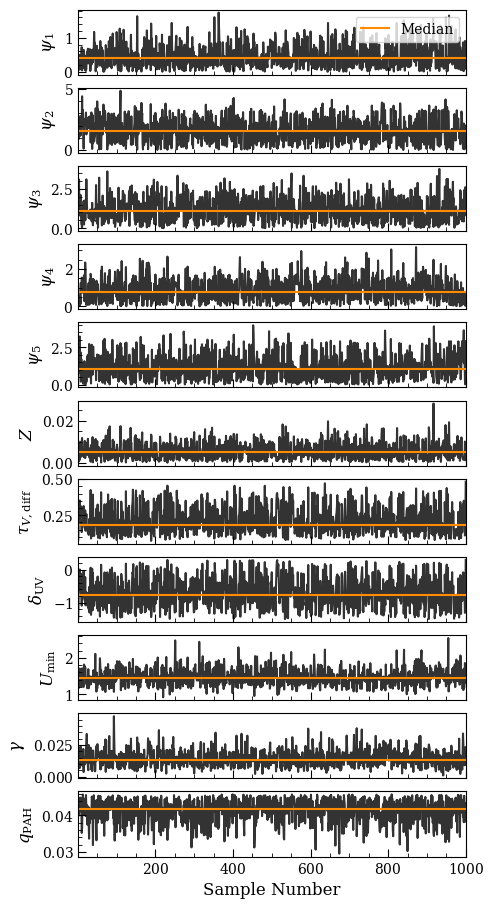

In [10]:
fig, axs = lgh_bp.chain_plot(chain, color='k', alpha=0.8)

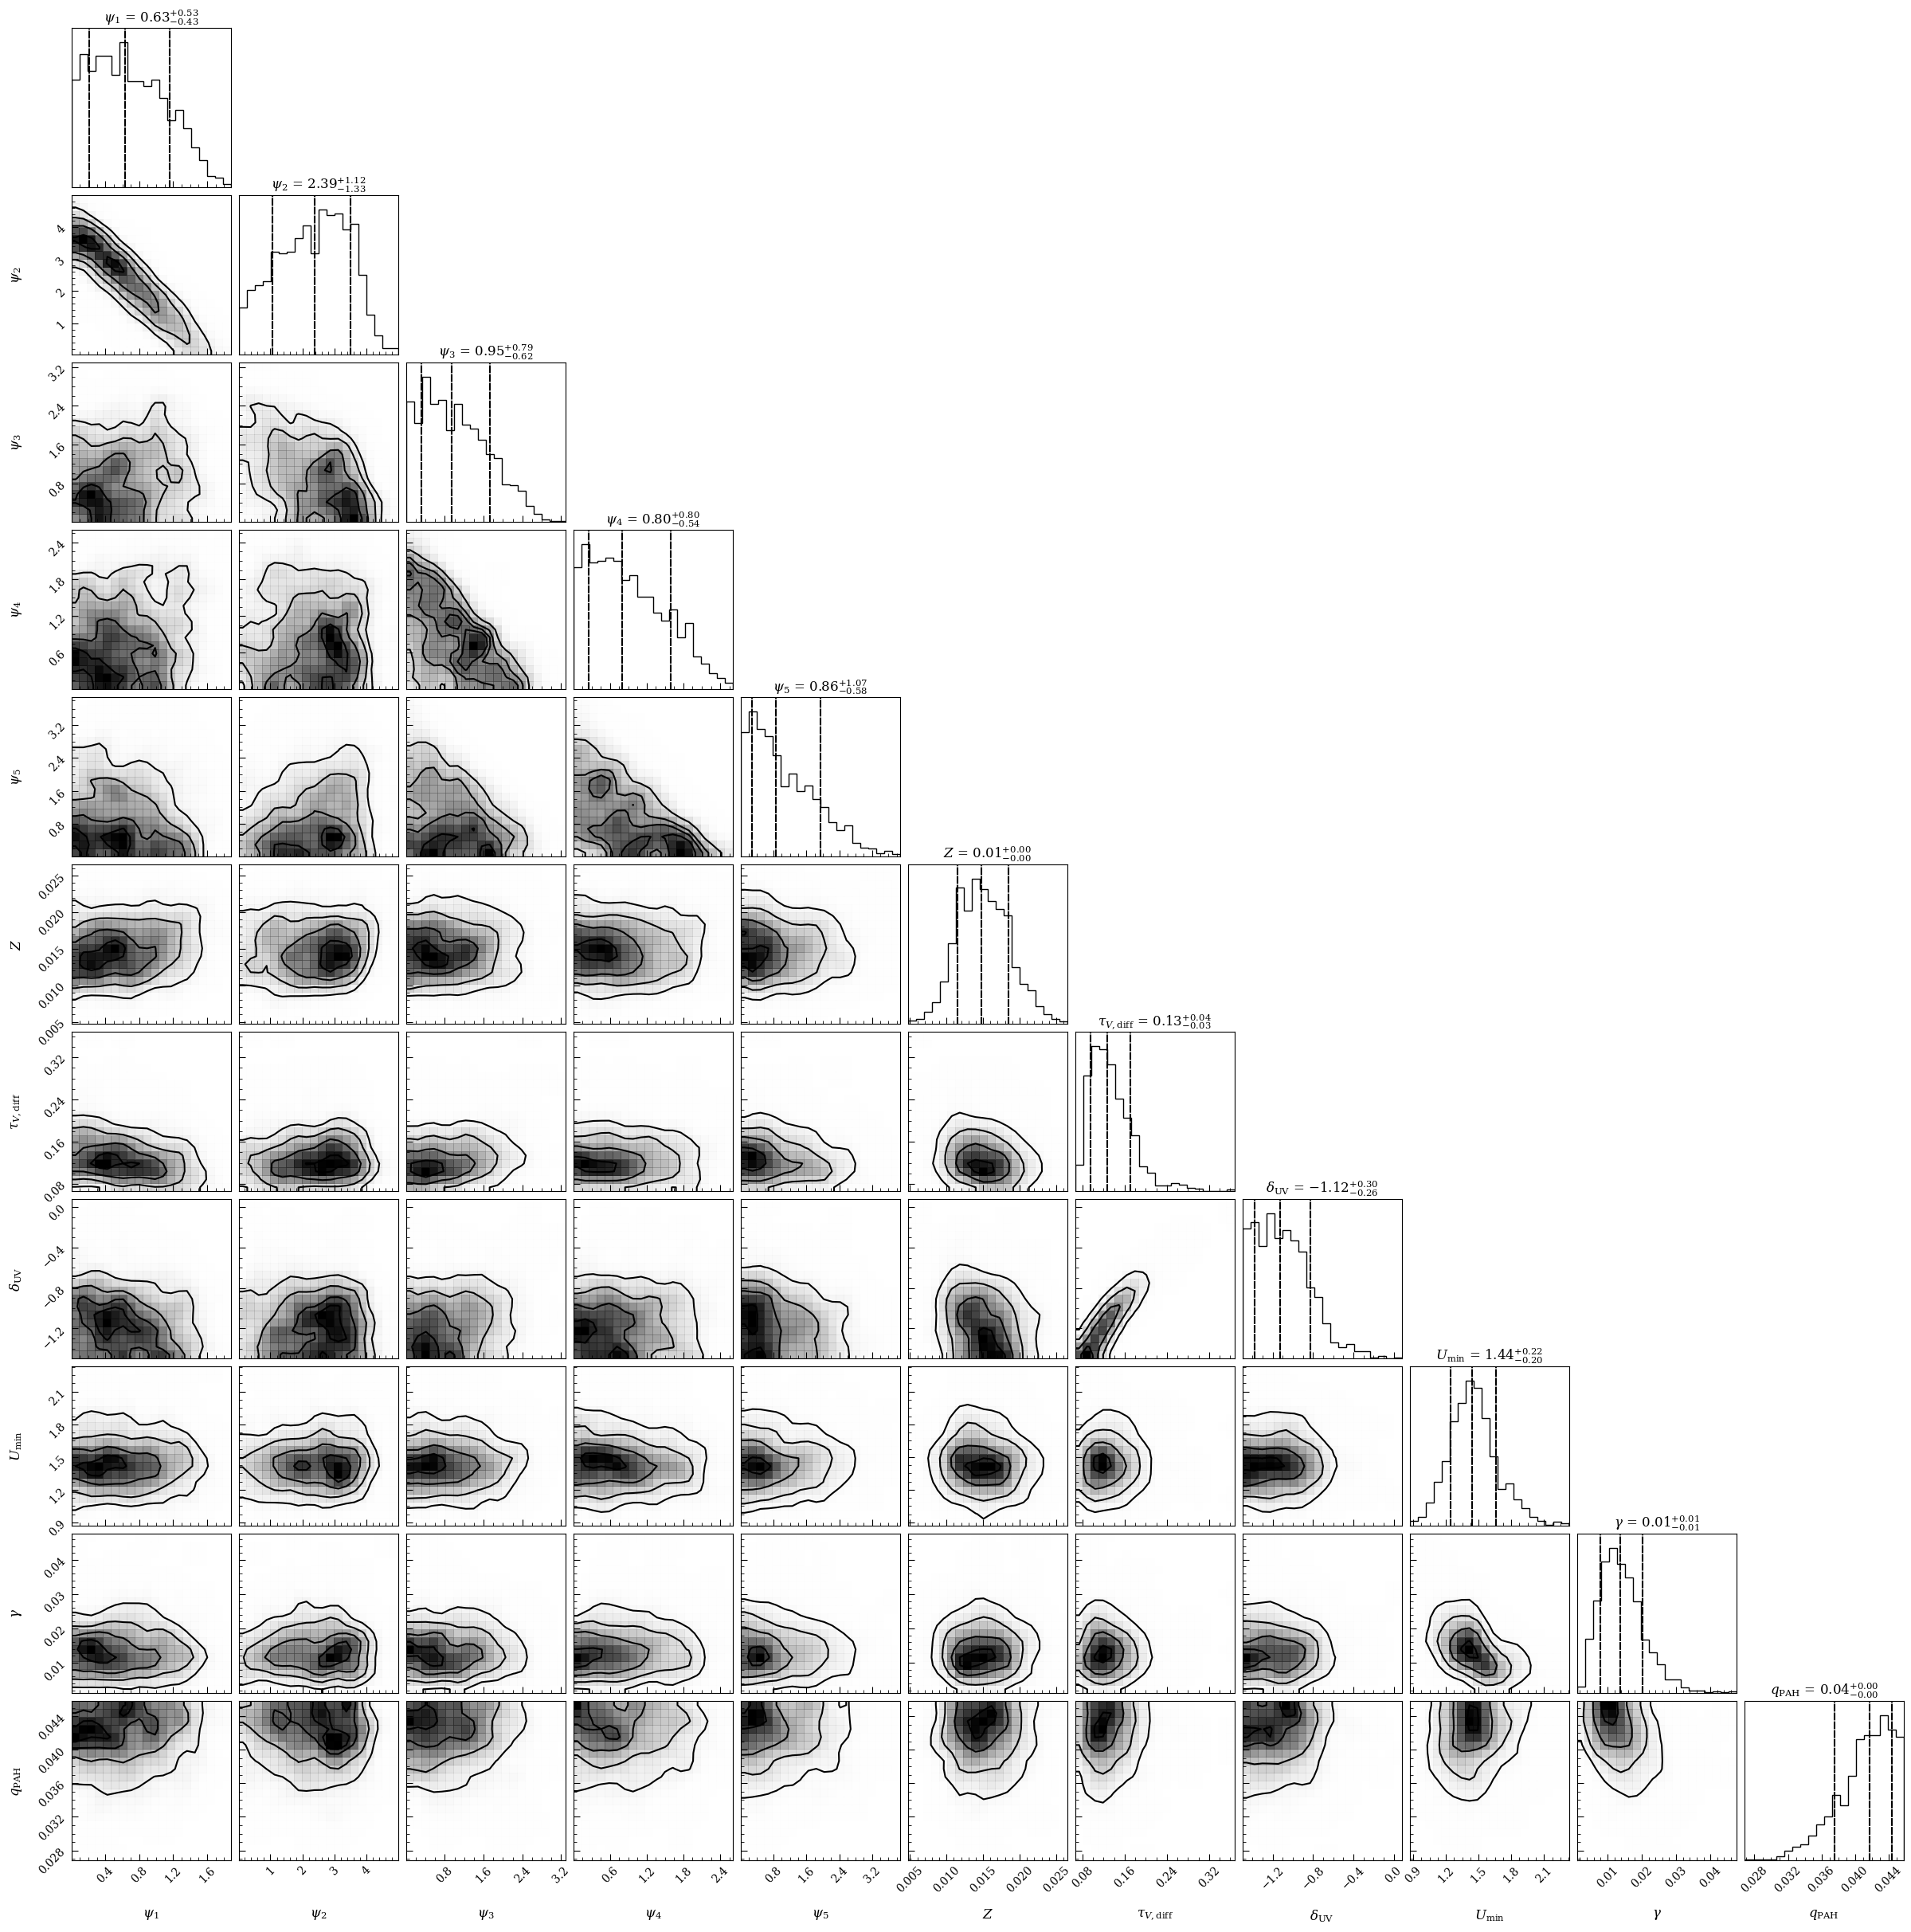

In [17]:
fig = lgh_bp.corner_plot(chain, 
                         quantiles=(0.16, 0.50, 0.84),
                         smooth=1,
                         levels=None,
                         show_titles=True)

/Users/eqm5663/Research/code/plightning/lightning/stellar/bpass.py:473: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.transpose(self.Lnu_obs, axes=[1,2,0,3])),
/Users/eqm5663/miniconda3/envs/ciao-4.15/lib/python3.10/site-packages/scipy/interpolate/_rgi.py:418: RuntimeWarning: invalid value encountered in multiply
  term = np.asarray(self.values[edge_indices]) * weight[vslice]
/Users/eqm5663/Research/code/plightning/lightning/stellar/bpass.py:473: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.transpose(self.Lnu_obs, axes=[1,2,0,3])),
/Users/eqm5663/miniconda3/envs/ciao-4.15/lib/python3.10/site-packages/scipy/interpolate/_rgi.py:418: RuntimeWarning: invalid value encountered in multiply
  term = np.asarray(self.values[edge_indices]) * weight[vslice]
/Users/eqm5663/miniconda3/envs/ciao-4.15/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdi

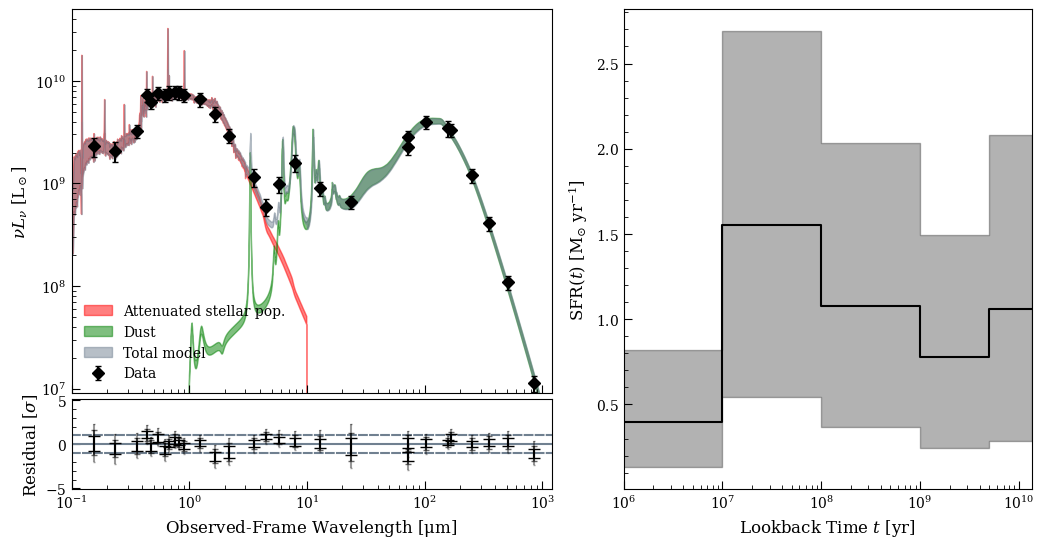

In [11]:
from lightning.plots import sed_plot_morebayesian, sed_plot_delchi_morebayesian, sfh_plot

fig5 = plt.figure(figsize=(12,6))
ax51 = fig5.add_axes([0.1, 0.26, 0.4, 0.64])
ax52 = fig5.add_axes([0.1, 0.1, 0.4, 0.15])
ax53 = fig5.add_axes([0.56, 0.1, 0.34, 0.8])

fig5, ax51 = sed_plot_morebayesian(lgh_bp, chain, logprob_chain,
                                   plot_components=True,
                                   ax=ax51,
                                   legend_kwargs={'loc': 'lower left', 'frameon': False})
ax51.set_xticklabels([])
fig5, ax52 = sed_plot_delchi_morebayesian(lgh_bp, chain, logprob_chain, ax=ax52)
fig5, ax53 = lgh_bp.sfh_plot(chain, ax=ax53)

p = 0.066


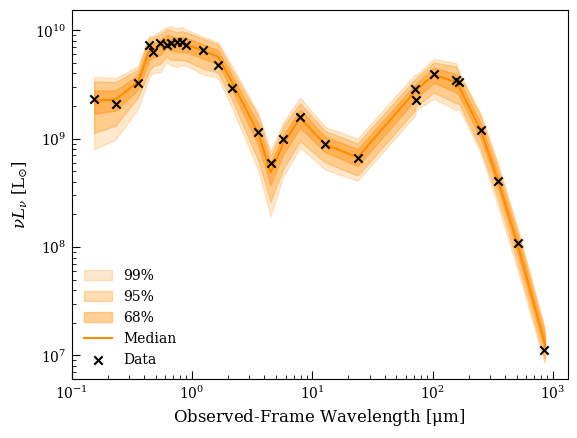

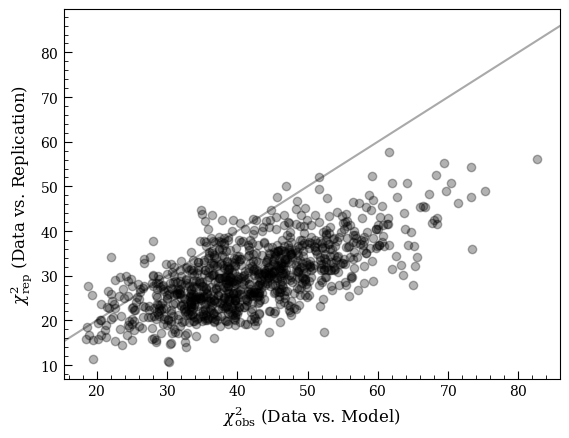

In [12]:
from lightning.ppc import ppc, ppc_sed

# I'm not thrilled about the way this works;
# the PPC needs all the parameters, even the constant
# ones. It's probably past time to make the MCMC fit function
# return a more user-friendly data structure that includes the
# constant values.
# param_arr = np.zeros((chain.shape[0], l.Nparams))
# param_arr[:, const_dim] = p[None, const_dim]
# param_arr[:, var_dim] = chain
 
pvalue, chi2_rep, chi2_obs = ppc(lgh_bp, chain,
                                 logprob_chain,
                                 Nrep=1000,
                                 seed=12345)
fig, ax = ppc_sed(lgh_bp, chain,
                  logprob_chain,
                  Nrep=1000,
                  seed=12345,
                  normalize=False)

fig2, ax2 = plt.subplots()

ax2.scatter(chi2_obs,
            chi2_rep,
            marker='o',
            alpha=0.3)

xlim = ax2.get_xlim()
ax2.plot(xlim, xlim, linestyle='-', color='darkgray', zorder=-1)
ax2.set_xlim(xlim)

ax2.set_xlabel(r'$\chi_{\rm obs}^2$ (Data vs. Model)')
ax2.set_ylabel(r'$\chi_{\rm rep}^2$ (Data vs. Replication)')


print('p = %.3f' % (pvalue))

and now we'll fit with Pégase to see if the solution changes:

In [13]:
print('PEGASE setup:')
lgh_pg = Lightning(filter_labels, 
                   lum_dist=dl, 
                   stellar_type='PEGASE',
                   SFH_type='Piecewise-Constant',
                   atten_type='Modified-Calzetti',
                   dust_emission=True,
                   model_unc=0.10,
                   print_setup_time=True)

lgh_pg.flux_obs = fnu_obs * 1e3
lgh_pg.flux_unc = fnu_unc * 1e3

PEGASE setup:
0.191 s elapsed in _get_filters
0.002 s elapsed in _get_wave_obs
0.635 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
1.518 s elapsed in dust emission model setup
0.000 s elapsed in agn emission model setup
0.000 s elapsed in X-ray model setup
2.345 s elapsed total


In [19]:
# p0_pg = np.array([5,5,0,0,0,
#                0.1, -1.0, 0.0,
#                2, 3, 3e5, 0.01, 0.02])

p0_seed_pg = np.array([5,5,0,0,0,
                       0.014,
                       0.1, -1.0, 0.0,
                       2, 3, 3e5, 0.01, 0.02])

priors_pg = 5 * [UniformPrior([0,100])] + \
            [NormalPrior([0.014, 0.01])] + \
            [UniformPrior([0,3]), UniformPrior([-1.5, 0.3]), None] + \
            [None, UniformPrior([0.1, 25]), None, UniformPrior([0,1]), UniformPrior([0.0047, 0.0458])]
const_dim = 5 * [False] + \
            [False] + \
            [False, False, True] + \
            [True, False, True, False, False]
const_dim = np.array(const_dim)
const_vals = p0_seed_pg[const_dim]

Nwalkers = 64
p0 = p0_seed_pg[None, :] + rng.normal(loc=0, scale=1e-5, size=(Nwalkers, len(p0_seed_pg)))
p0[:, const_dim] = p0_seed_pg[const_dim]

print('PEGASE Model:')
mcmc_pg = lgh_pg.fit(p0,
                     method='emcee',
                     priors=priors_pg,
                     const_dim=const_dim,
                     #MCMC_kwargs={'Nwalkers':128,'Nsteps':1000, 'init_scale':1e-3, 'progress':True},
                     Nwalkers=Nwalkers,
                     Nsteps=30000,
                     progress=True)


/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:429: RuntimeWarning: divide by zero encountered in log10
  finterp = interp1d(self.Zmet, np.log10(self.Lnu_obs), axis=1)
/Users/eqm5663/miniconda3/envs/ciao-4.15/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


PEGASE Model:


  0%|                                                                     | 0/30000 [00:00<?, ?it/s]/Users/eqm5663/miniconda3/envs/ciao-4.15/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|█████████████████████████████████████████████████████████| 30000/30000 [11:38<00:00, 42.95it/s]


In [20]:
print('MCMC mean acceptance fraction: %.3f' % (np.mean(mcmc_pg.acceptance_fraction)))

MCMC mean acceptance fraction: 0.274


In [21]:
chain, logprob_chain, tau_ac = lgh_pg.get_mcmc_chains(mcmc_pg, discard=2000, thin=500, const_dim=const_dim, const_vals=p0_seed_pg[const_dim])

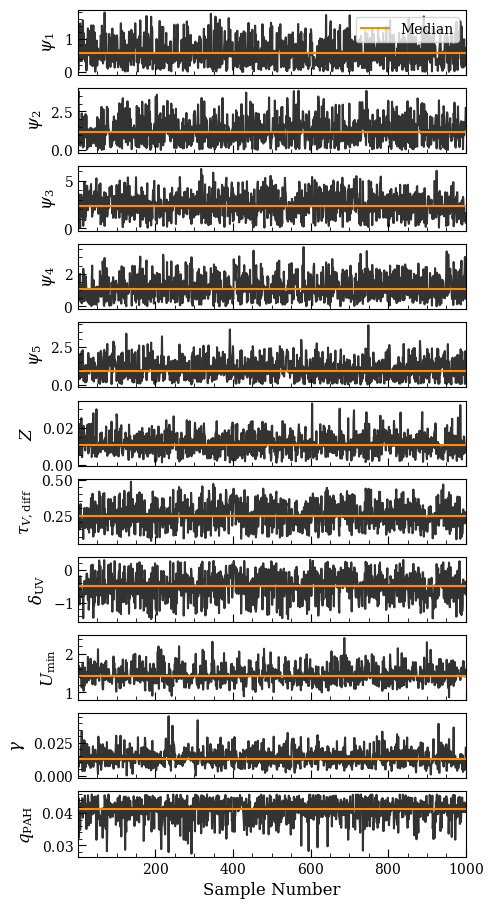

In [22]:
fig, axs = lgh_pg.chain_plot(chain, color='k', alpha=0.8)

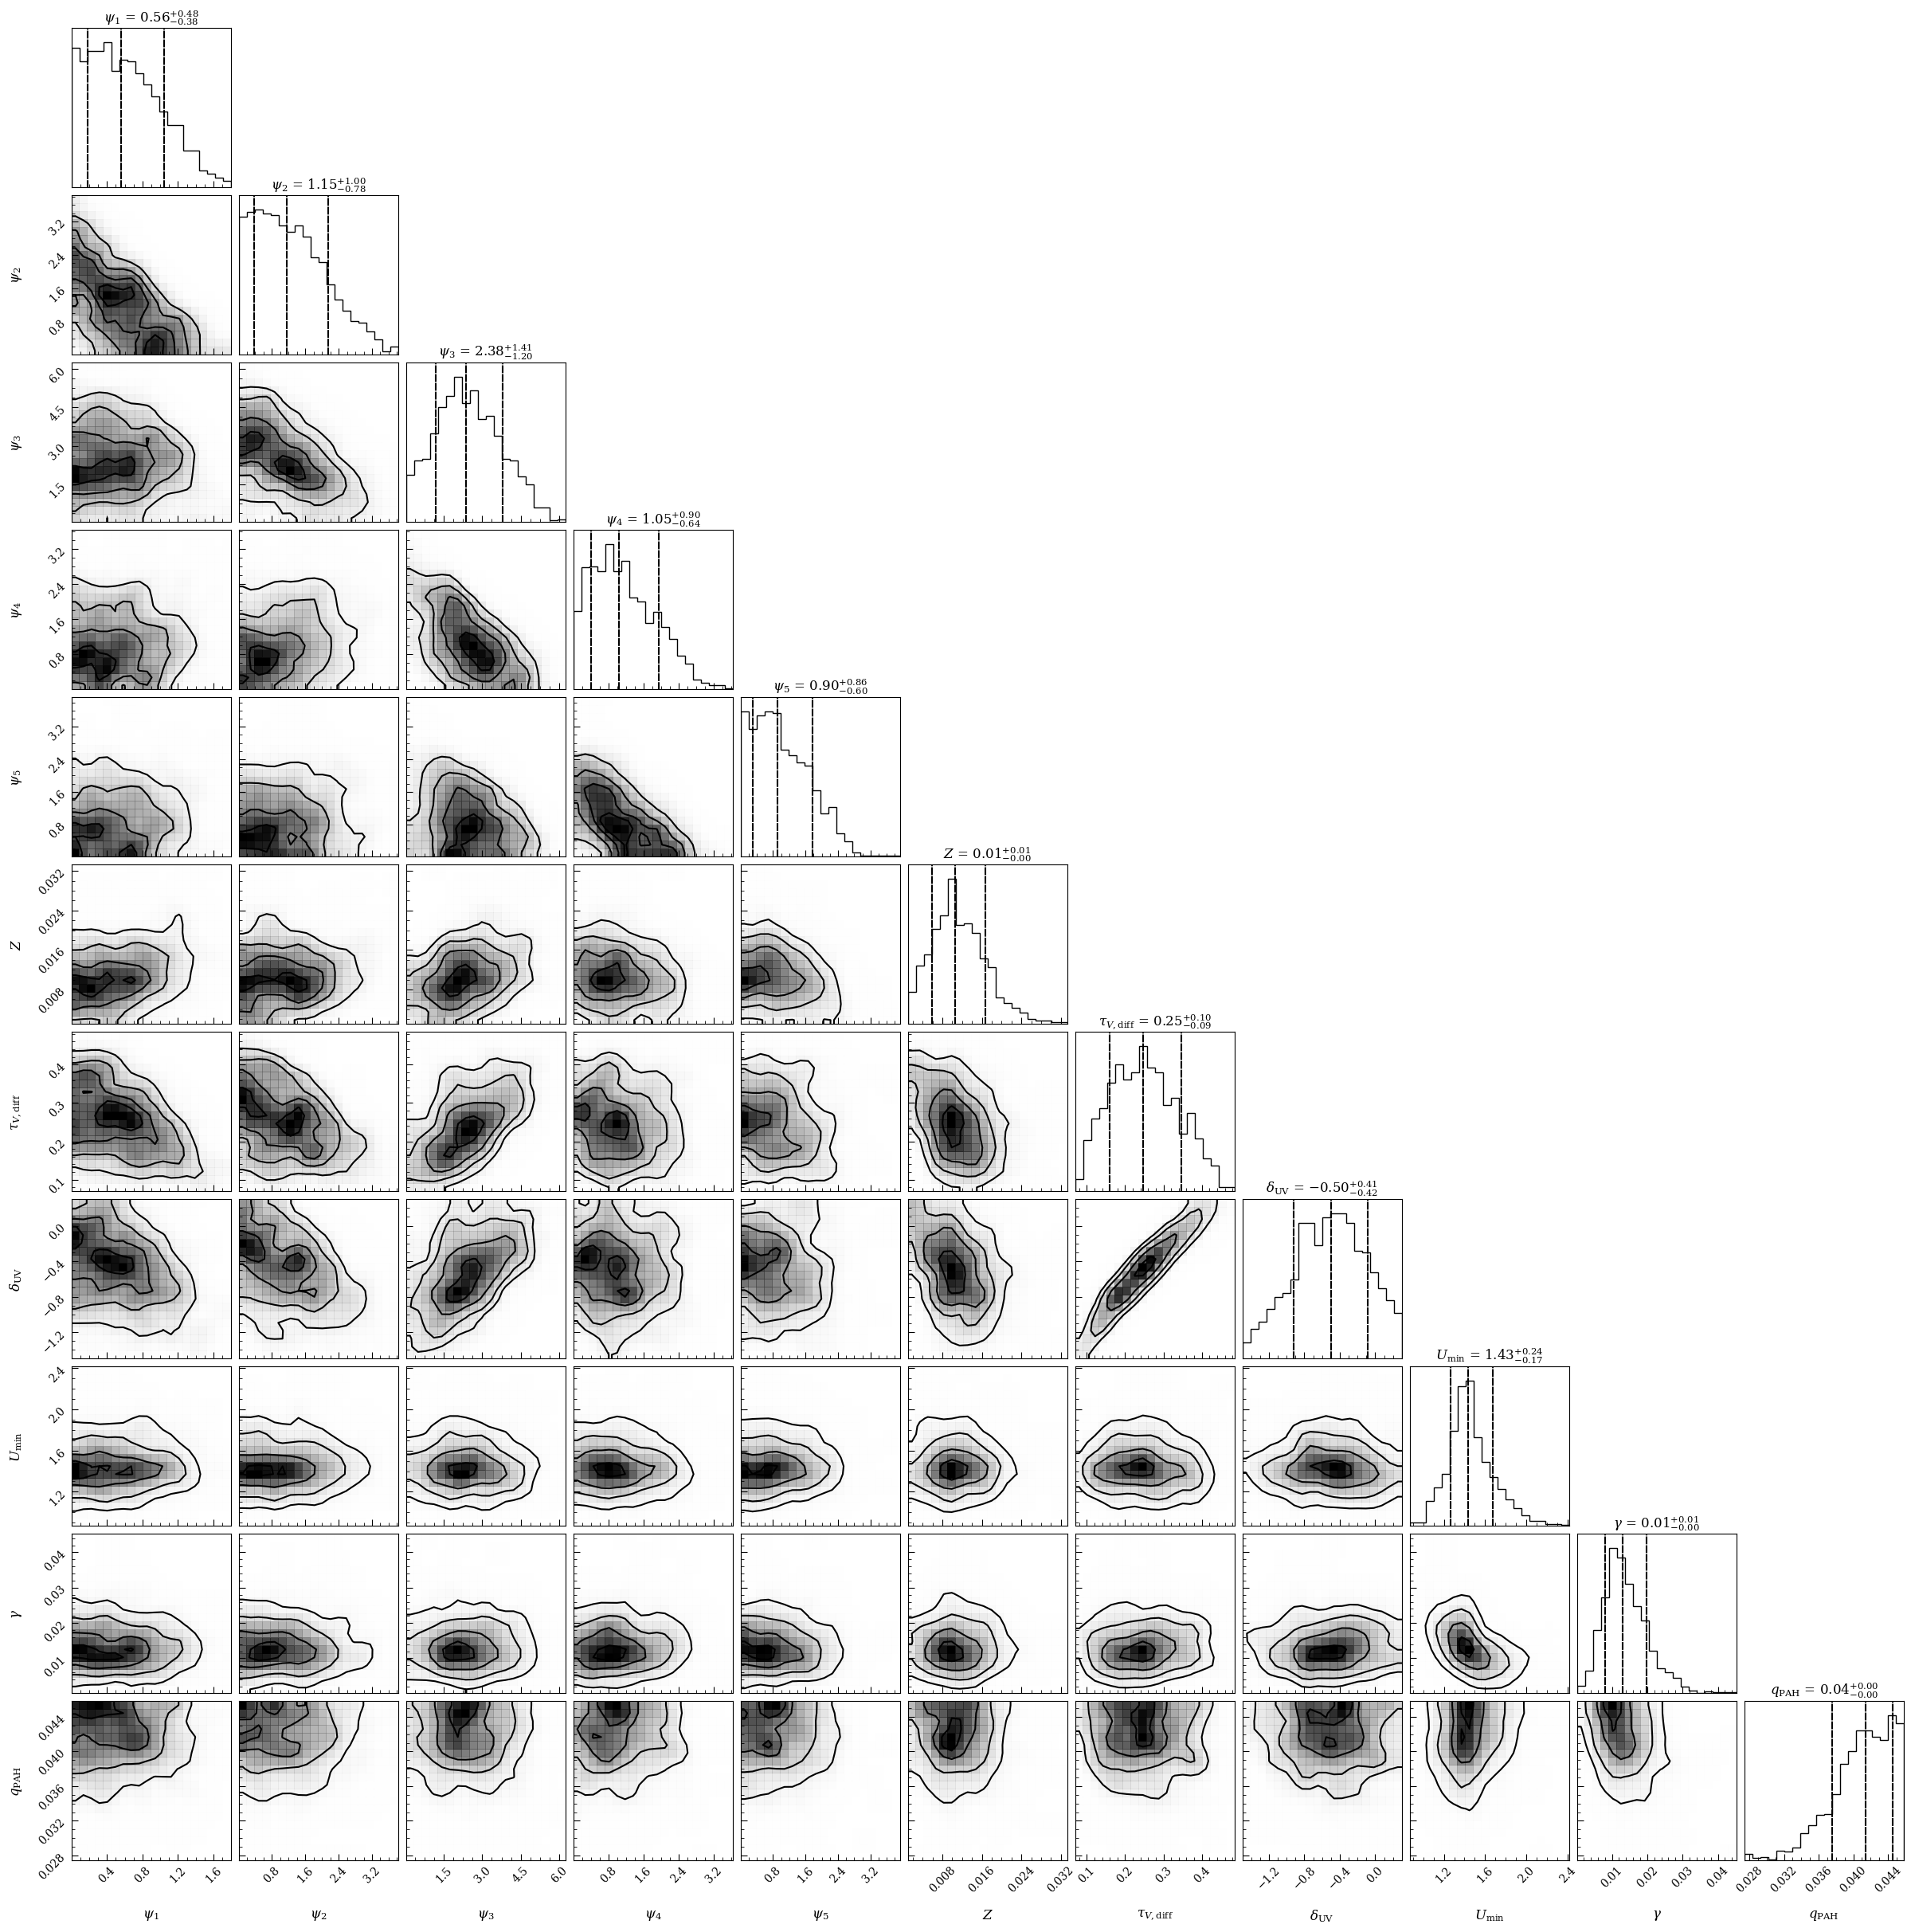

In [23]:
fig = lgh_pg.corner_plot(chain, 
                         quantiles=(0.16, 0.50, 0.84),
                         smooth=1,
                         levels=None,
                         show_titles=True)

/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:429: RuntimeWarning: divide by zero encountered in log10
  finterp = interp1d(self.Zmet, np.log10(self.Lnu_obs), axis=1)
/Users/eqm5663/miniconda3/envs/ciao-4.15/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:429: RuntimeWarning: divide by zero encountered in log10
  finterp = interp1d(self.Zmet, np.log10(self.Lnu_obs), axis=1)
/Users/eqm5663/miniconda3/envs/ciao-4.15/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/eqm5663/miniconda3/envs/ciao-4.15/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, ke

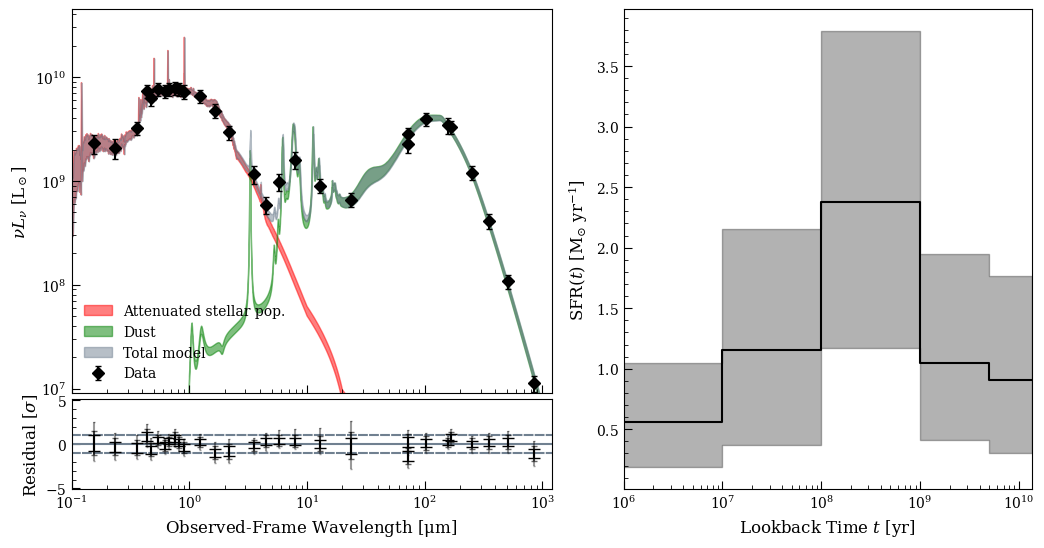

In [24]:
from lightning.plots import sed_plot_morebayesian, sed_plot_delchi_morebayesian, sfh_plot

fig5 = plt.figure(figsize=(12,6))
ax51 = fig5.add_axes([0.1, 0.26, 0.4, 0.64])
ax52 = fig5.add_axes([0.1, 0.1, 0.4, 0.15])
ax53 = fig5.add_axes([0.56, 0.1, 0.34, 0.8])

fig5, ax51 = sed_plot_morebayesian(lgh_pg, chain, logprob_chain,
                                   plot_components=True,
                                   ax=ax51,
                                   legend_kwargs={'loc': 'lower left', 'frameon': False})
ax51.set_xticklabels([])
fig5, ax52 = sed_plot_delchi_morebayesian(lgh_pg, chain, logprob_chain, ax=ax52)
fig5, ax53 = lgh_pg.sfh_plot(chain, ax=ax53)

The SFHs are still consistent (in that there's no strong constraint on the shape at $t > 10^7$ yr), but the Pegase solution favors an even lower metallicity.

p = 0.087


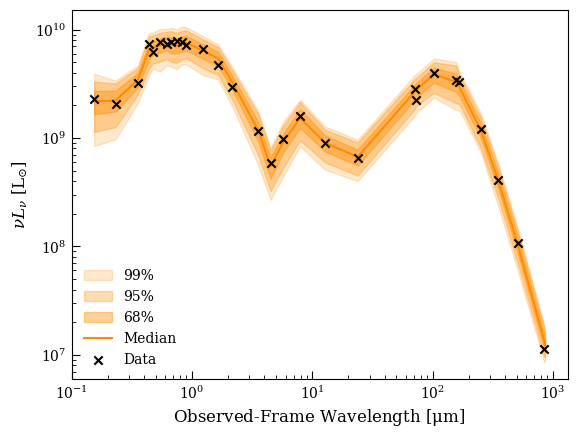

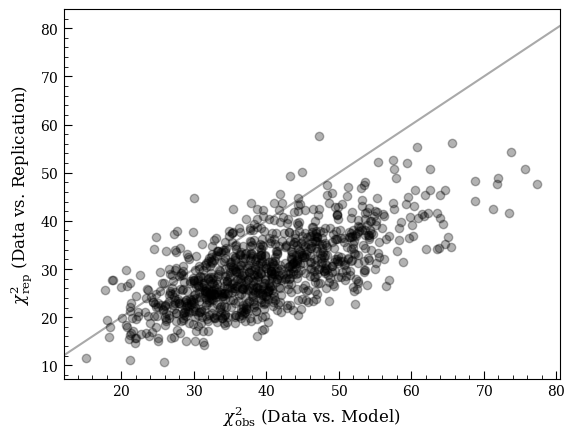

In [26]:
from lightning.ppc import ppc, ppc_sed

# I'm not thrilled about the way this works;
# the PPC needs all the parameters, even the constant
# ones. It's probably past time to make the MCMC fit function
# return a more user-friendly data structure that includes the
# constant values.
# param_arr = np.zeros((chain.shape[0], l.Nparams))
# param_arr[:, const_dim] = p[None, const_dim]
# param_arr[:, var_dim] = chain
 
pvalue, chi2_rep, chi2_obs = ppc(lgh_pg, chain,
                                 logprob_chain,
                                 Nrep=1000,
                                 seed=12345)
fig, ax = ppc_sed(lgh_pg, chain,
                  logprob_chain,
                  Nrep=1000,
                  seed=12345,
                  normalize=False)

fig2, ax2 = plt.subplots()

ax2.scatter(chi2_obs,
            chi2_rep,
            marker='o',
            alpha=0.3)

xlim = ax2.get_xlim()
ax2.plot(xlim, xlim, linestyle='-', color='darkgray', zorder=-1)
ax2.set_xlim(xlim)

ax2.set_xlabel(r'$\chi_{\rm obs}^2$ (Data vs. Model)')
ax2.set_ylabel(r'$\chi_{\rm rep}^2$ (Data vs. Replication)')


print('p = %.3f' % (pvalue))

Flexible metallicity is giving us a better fit overall in both cases.